# Notebook 01: FFT Spectrum Catalog

**Purpose**: Generate complete frequency spectrum from FFT analysis of Enoch calendar Day 1 oscillations

**Outputs**:
- `outputs/csvs/fft_spectrum.csv` - Complete frequency catalog with power levels
- `outputs/csvs/data_metadata.csv` - Data characteristics and sampling info
- `outputs/figures/01_power_spectrum.png` - Power spectrum visualization

**Execution time**: ~2-3 minutes

---

## Overview

This notebook performs Fast Fourier Transform (FFT) on the complete Enoch calendar dataset to:
1. Identify all periodic frequencies in the Day 1 oscillation pattern
2. Measure power levels for each frequency
3. Classify frequencies as 294-day multiples
4. Calculate precession coupling fractions
5. Analyze power distribution across frequency bands

The resulting frequency catalog serves as the foundation for model selection in Notebook 02.

## Setup

In [1]:
import sys
import os
sys.path.insert(0, '../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import swisseph as swe
from scipy.fft import fft, fftfreq

# Import Enoch calendar modules
from src.enoch import enoch_calendar_frame, merge_astronomic_data
from src.harmonic_analysis import HarmonicAnalyzer

# Configure Swiss Ephemeris
from src.enoch_config import SWISS_EPH_PATH
swe.set_ephe_path(SWISS_EPH_PATH)
swe.set_jpl_file('de441.eph')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

%matplotlib inline

print("✓ Setup complete")
print(f"  Python path: {sys.path[0]}")
print(f"  Swiss Ephemeris: {swe.get_library_path()}")

✓ Setup complete
  Python path: /Users/meetri/dev/apps/python/enoch-manuscript/code/
  Swiss Ephemeris: /Users/meetri/anaconda3/envs/enoch/lib/python3.11/site-packages/swisseph.cpython-311-darwin.so


## Parameters

In [2]:
# Calendar data generation parameters
YEAR_START = -12762  # Optimal epoch
NUM_CYCLES = 100     # 100 cycles × 294 years = 29,400 Day 1 events

# Physical constants
PRECESSION_PERIOD = 25772  # Earth's axial precession period (years)
CORRECTION_PERIOD = 294    # Enoch calendar correction period (days)
CALENDAR_YEAR = 364        # Enoch calendar year length (days)

# Output directories
OUTPUT_CSV_DIR = 'outputs/csvs'
OUTPUT_FIG_DIR = 'outputs/figures'

print("Parameters:")
print(f"  Calendar epoch: {YEAR_START} CE")
print(f"  Number of cycles: {NUM_CYCLES}")
print(f"  Expected Day 1 events: {NUM_CYCLES * 100} (100 per cycle)")
print(f"  Time span: ~{NUM_CYCLES * 294} years")
print(f"  Precession period: {PRECESSION_PERIOD:,} years")

Parameters:
  Calendar epoch: -12762 CE
  Number of cycles: 100
  Expected Day 1 events: 10000 (100 per cycle)
  Time span: ~29400 years
  Precession period: 25,772 years


## Load Calendar Data

In [3]:
print("Loading Enoch calendar data...")
print(f"  Generating {NUM_CYCLES} cycles starting from {YEAR_START} CE")

# Generate calendar frame
e_df = enoch_calendar_frame(num_cycles=NUM_CYCLES)

# Merge with astronomical data
a_df = merge_astronomic_data(e_df, YEAR_START, use_tt=True)

# Calculate solar year from enoch_year + YEAR_START
a_df['solar_year'] = a_df['enoch_year'] + YEAR_START

# Filter to Day 1 events only
day1_data = a_df[a_df.enoch_solar_doy == 1].copy()
day1_data = day1_data.sort_values('solar_year').reset_index(drop=True)

# Extract time series
years = day1_data['solar_year'].values
ecliptic = day1_data['sun_ecliptic_longitude_neg'].values

# Remove NaN values
valid_mask = ~np.isnan(ecliptic)
years = years[valid_mask]
ecliptic = ecliptic[valid_mask]

print(f"\n✓ Data loaded successfully")
print(f"  Total Day 1 events: {len(years):,}")
print(f"  Year range: {years.min():.0f} to {years.max():.0f} CE")
print(f"  Time span: {years.max() - years.min():.0f} years")
print(f"  Ecliptic longitude range: {ecliptic.min():.2f}° to {ecliptic.max():.2f}°")
print(f"  Mean: {ecliptic.mean():.2f}°, Std: {ecliptic.std():.2f}°")

Loading Enoch calendar data...
  Generating 100 cycles starting from -12762 CE



✓ Data loaded successfully
  Total Day 1 events: 29,400
  Year range: -12762 to 16636 CE
  Time span: 29398 years
  Ecliptic longitude range: -2.53° to 5.11°
  Mean: 0.15°, Std: 1.57°


## Data Characteristics & Metadata

In [4]:
# Analyze sampling characteristics
year_diffs = np.diff(years)
sampling_rate_median = np.median(year_diffs)
sampling_rate_mean = np.mean(year_diffs)
sampling_rate_std = np.std(year_diffs)

# Identify gaps
gaps = year_diffs[year_diffs > sampling_rate_median * 1.5]
n_gaps = len(gaps)

# Create metadata dictionary
data_metadata = {
    'n_points': len(years),
    'year_min': years.min(),
    'year_max': years.max(),
    'year_span': years.max() - years.min(),
    'sampling_rate_median': sampling_rate_median,
    'sampling_rate_mean': sampling_rate_mean,
    'sampling_rate_std': sampling_rate_std,
    'n_gaps': n_gaps,
    'max_gap': gaps.max() if n_gaps > 0 else 0,
    'ecliptic_min': ecliptic.min(),
    'ecliptic_max': ecliptic.max(),
    'ecliptic_mean': ecliptic.mean(),
    'ecliptic_std': ecliptic.std(),
    'ecliptic_range': ecliptic.max() - ecliptic.min()
}

print("Data Characteristics:")
print(f"  Sampling rate (median): {sampling_rate_median:.6f} years")
print(f"  Sampling rate (mean): {sampling_rate_mean:.6f} years")
print(f"  Sampling rate (std): {sampling_rate_std:.6f} years")
print(f"  Number of gaps (>1.5× median): {n_gaps}")
if n_gaps > 0:
    print(f"  Maximum gap: {gaps.max():.2f} years")

# Save metadata
metadata_df = pd.DataFrame([data_metadata])
metadata_path = f'{OUTPUT_CSV_DIR}/data_metadata.csv'
metadata_df.to_csv(metadata_path, index=False)
print(f"\n✓ Metadata saved: {metadata_path}")

Data Characteristics:
  Sampling rate (median): 1.000000 years
  Sampling rate (mean): 0.999966 years
  Sampling rate (std): 0.082274 years
  Number of gaps (>1.5× median): 99
  Maximum gap: 2.00 years

✓ Metadata saved: outputs/csvs/data_metadata.csv


## Initialize Harmonic Analyzer & Perform FFT

In [5]:
print("Initializing HarmonicAnalyzer...")
analyzer = HarmonicAnalyzer(years, ecliptic)

print("\nPerforming FFT (this may take 1-2 minutes)...")
# Perform FFT - initially request top 50 peaks for cataloging
top_50_periods = analyzer.perform_fft(n_peaks=50)

print(f"\n✓ FFT analysis complete")
print(f"  Total frequencies analyzed: {len(analyzer.fft_frequencies):,}")
print(f"  Top 50 periods identified")
print(f"  Frequency range: {analyzer.fft_frequencies.min():.8f} to {analyzer.fft_frequencies.max():.8f} Hz")

Initializing HarmonicAnalyzer...

Performing FFT (this may take 1-2 minutes)...
=== FFT Analysis Results ===
Analyzed 29400 data points spanning 29398 years
Sampling cadence (median): 1.000000 years

Top 50 dominant periodic components:
  1. Period:    14700.0 years (power: 2.15e+04)
  2. Period:    29400.0 years (power: 1.72e+04)
  3. Period:     9800.0 years (power: 9.67e+03)
  4. Period:     7350.0 years (power: 6.57e+03)
  5. Period:     5880.0 years (power: 5.07e+03)
  6. Period:     4900.0 years (power: 4.15e+03)
  7. Period:        4.1 years (power: 4.07e+03)
  8. Period:     4200.0 years (power: 3.51e+03)
  9. Period:     3675.0 years (power: 3.05e+03)
  10. Period:     3266.7 years (power: 2.70e+03)
  11. Period:     2940.0 years (power: 2.42e+03)
  12. Period:     2672.7 years (power: 2.20e+03)
  13. Period:     2450.0 years (power: 2.01e+03)
  14. Period:     2261.5 years (power: 1.85e+03)
  15. Period:     2100.0 years (power: 1.72e+03)
  16. Period:        2.1 years (power

/Users/meetri/dev/apps/python/enoch-manuscript/code/src/harmonic_analysis.py:122: RuntimeWarning: Detected irregular year spacing (199 anomalies, median step 1.000000). FFT results now use the median cadence; consider resampling for highest fidelity.
  warnings.warn(


## Build Complete Frequency Catalog

In [6]:
print("Building complete frequency catalog...")

# Extract FFT data
frequencies = analyzer.fft_frequencies
power = analyzer.fft_power
periods = 1.0 / frequencies

# Calculate power metrics
total_power = np.sum(power)
power_pct = (power / total_power) * 100
cumulative_power_pct = np.cumsum(power_pct[np.argsort(power)[::-1]])

# Create base catalog
catalog_data = {
    'frequency': frequencies,
    'period': periods,
    'power': power,
    'power_pct': power_pct
}

# Classify 294-multiples
n_values = periods / CORRECTION_PERIOD
is_294_multiple = np.abs(n_values - np.round(n_values)) < 0.05  # Within 5% tolerance
n_values_rounded = np.round(n_values)

catalog_data['is_294_multiple'] = is_294_multiple
catalog_data['n_value'] = n_values
catalog_data['n_rounded'] = n_values_rounded

# Calculate precession coupling
# Test common fractions: 1/8, 2/7, 3/8, 4/7, 1/2, 5/8, 6/7, 7/8, 1, 8/7, 9/7, 10/7, etc.
precession_fractions = [
    (1, 8), (2, 7), (3, 8), (4, 7), (1, 2), (5, 8), (6, 7), (7, 8),
    (1, 1), (8, 7), (9, 7), (10, 7), (11, 7), (12, 7), (2, 1)
]

precession_fraction_strings = []
coupling_errors = []

for period in periods:
    # Find closest precession fraction
    best_fraction = None
    best_error = float('inf')
    
    for num, denom in precession_fractions:
        target_period = PRECESSION_PERIOD * num / denom
        error_pct = abs(period - target_period) / target_period * 100
        
        if error_pct < best_error:
            best_error = error_pct
            best_fraction = f"{num}/{denom}"
    
    precession_fraction_strings.append(best_fraction if best_error < 5.0 else "none")
    coupling_errors.append(best_error if best_error < 5.0 else np.nan)

catalog_data['precession_fraction'] = precession_fraction_strings
catalog_data['coupling_error_pct'] = coupling_errors

# Classify by frequency band
frequency_bands = []
for period in periods:
    if period < 1000:
        frequency_bands.append('short')
    elif period < 10000:
        frequency_bands.append('medium')
    else:
        frequency_bands.append('long')

catalog_data['frequency_band'] = frequency_bands

# Create DataFrame
spectrum_catalog = pd.DataFrame(catalog_data)

# Sort by power (descending)
spectrum_catalog = spectrum_catalog.sort_values('power', ascending=False).reset_index(drop=True)

# Add cumulative power (after sorting)
spectrum_catalog['cumulative_power_pct'] = np.cumsum(spectrum_catalog['power_pct'])

print(f"\n✓ Frequency catalog built")
print(f"  Total frequencies: {len(spectrum_catalog):,}")
print(f"  294-multiples: {is_294_multiple.sum():,} ({is_294_multiple.sum()/len(spectrum_catalog)*100:.1f}%)")
print(f"  Precession-coupled (<5% error): {sum(1 for x in coupling_errors if not np.isnan(x))}")
print(f"\nFrequency band distribution:")
print(f"  Short (<1,000 yr): {sum(1 for x in frequency_bands if x=='short')}")
print(f"  Medium (1,000-10,000 yr): {sum(1 for x in frequency_bands if x=='medium')}")
print(f"  Long (>10,000 yr): {sum(1 for x in frequency_bands if x=='long')}")

Building complete frequency catalog...

✓ Frequency catalog built
  Total frequencies: 14,699
  294-multiples: 12,720 (86.5%)
  Precession-coupled (<5% error): 5

Frequency band distribution:
  Short (<1,000 yr): 14670
  Medium (1,000-10,000 yr): 27
  Long (>10,000 yr): 2


## Power Distribution Analysis

In [7]:
# Analyze power concentration
top_10_power = spectrum_catalog.head(10)['power_pct'].sum()
top_20_power = spectrum_catalog.head(20)['power_pct'].sum()
top_50_power = spectrum_catalog.head(50)['power_pct'].sum()
top_100_power = spectrum_catalog.head(100)['power_pct'].sum()

# 294-multiple contribution
multiples_294_power = spectrum_catalog[spectrum_catalog['is_294_multiple']]['power_pct'].sum()

# Precession-coupled contribution
precession_coupled_power = spectrum_catalog[spectrum_catalog['precession_fraction'] != 'none']['power_pct'].sum()

print("Power Distribution Analysis:")
print(f"  Top 10 frequencies: {top_10_power:.2f}% of total power")
print(f"  Top 20 frequencies: {top_20_power:.2f}% of total power")
print(f"  Top 50 frequencies: {top_50_power:.2f}% of total power")
print(f"  Top 100 frequencies: {top_100_power:.2f}% of total power")
print(f"\n  294-multiples: {multiples_294_power:.2f}% of total power")
print(f"  Precession-coupled: {precession_coupled_power:.2f}% of total power")

print(f"\nTop 10 Frequencies:")
print(spectrum_catalog.head(10)[[
    'period', 'power', 'power_pct', 'cumulative_power_pct',
    'is_294_multiple', 'n_rounded', 'precession_fraction', 'coupling_error_pct'
]].to_string(index=False))

Power Distribution Analysis:
  Top 10 frequencies: 25.13% of total power
  Top 20 frequencies: 30.96% of total power
  Top 50 frequencies: 39.72% of total power
  Top 100 frequencies: 46.64% of total power

  294-multiples: 53.20% of total power
  Precession-coupled: 18.70% of total power

Top 10 Frequencies:
      period        power  power_pct  cumulative_power_pct  is_294_multiple  n_rounded precession_fraction  coupling_error_pct
14700.000000 21546.242762   6.981077              6.981077             True       50.0                 4/7            0.182368
29400.000000 17213.323153   5.577192             12.558269             True      100.0                 8/7            0.182368
 9800.000000  9672.118110   3.133809             15.692077            False       33.0                 3/8            1.402038
 7350.000000  6573.321205   2.129785             17.821862             True       25.0                 2/7            0.182368
 5880.000000  5069.580703   1.642566             19.46

## Save Frequency Catalog

In [8]:
# Save complete catalog
catalog_path = f'{OUTPUT_CSV_DIR}/fft_spectrum.csv'
spectrum_catalog.to_csv(catalog_path, index=False)

print(f"✓ Frequency catalog saved: {catalog_path}")
print(f"  Rows: {len(spectrum_catalog):,}")
print(f"  Columns: {len(spectrum_catalog.columns)}")
print(f"  Size: {spectrum_catalog.memory_usage(deep=True).sum() / 1024:.1f} KB")

✓ Frequency catalog saved: outputs/csvs/fft_spectrum.csv
  Rows: 14,699
  Columns: 11
  Size: 2698.8 KB


## Visualization: Power Spectrum

/var/folders/fd/mpth0kns6lbdm48fpdjvg9mw0000gn/T/ipykernel_88029/4256820180.py:85: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()



✓ Power spectrum figure saved: outputs/figures/01_power_spectrum.png


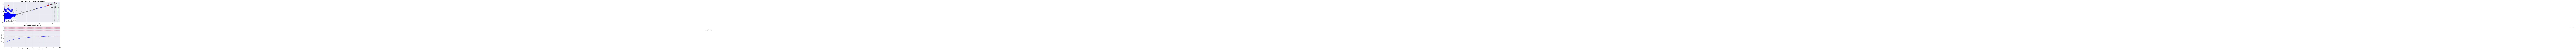

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# ========================================
# Panel A: Log-Log Power Spectrum
# ========================================
ax1 = axes[0]

# Separate 294-multiples from others
multiples_294 = spectrum_catalog[spectrum_catalog['is_294_multiple']]
non_multiples = spectrum_catalog[~spectrum_catalog['is_294_multiple']]

# Plot all frequencies
ax1.scatter(non_multiples['period'], non_multiples['power'], 
           s=10, alpha=0.4, color='gray', label='Other frequencies')

# Highlight 294-multiples
ax1.scatter(multiples_294['period'], multiples_294['power'],
           s=30, alpha=0.7, color='blue', label='294-day multiples', zorder=3)

# Highlight top 10
top_10 = spectrum_catalog.head(10)
ax1.scatter(top_10['period'], top_10['power'],
           s=80, alpha=0.9, color='red', marker='*', 
           edgecolors='black', linewidth=0.5,
           label='Top 10 strongest', zorder=4)

# Mark precession period
ax1.axvline(PRECESSION_PERIOD, color='green', linestyle='--', 
           linewidth=2, alpha=0.7, label=f'Precession ({PRECESSION_PERIOD:,} yr)')

# Set scales and limits BEFORE text annotations
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(2, 40000)  # Set explicit x limits
ax1.set_ylim(1e-1, 3e4)  # Set explicit y limits

# Mark key precession fractions (AFTER setting limits)
for num, denom in [(3, 8), (4, 7), (8, 7)]:
    period = PRECESSION_PERIOD * num / denom
    if 2 < period < 40000:  # Only plot if in range
        ax1.axvline(period, color='green', linestyle=':', linewidth=1, alpha=0.4)
        ax1.text(period, 2e4, f'{num}/{denom}',
                rotation=90, va='top', ha='right', fontsize=7, color='green')

ax1.set_xlabel('Period (years)', fontsize=11)
ax1.set_ylabel('FFT Power', fontsize=11)
ax1.set_title('Power Spectrum: All Frequencies (Log-Log)', fontsize=12, weight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# Add text annotation
ax1.text(0.02, 0.02, 
        f'Total frequencies: {len(spectrum_catalog):,}\n'
        f'294-multiples: {len(multiples_294)} ({len(multiples_294)/len(spectrum_catalog)*100:.1f}%)\n'
        f'Top 10 power: {top_10_power:.1f}%',
        transform=ax1.transAxes, fontsize=8, verticalalignment='bottom',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# ========================================
# Panel B: Cumulative Power Distribution
# ========================================
ax2 = axes[1]

# Plot cumulative power
ax2.plot(range(1, len(spectrum_catalog) + 1), 
        spectrum_catalog['cumulative_power_pct'],
        'b-', linewidth=2, alpha=0.7)

# Mark key thresholds
for pct in [50, 80, 90, 95]:
    idx = np.argmax(spectrum_catalog['cumulative_power_pct'] >= pct)
    n_freqs = idx + 1
    ax2.axhline(pct, color='red', linestyle='--', linewidth=1, alpha=0.3)
    ax2.axvline(n_freqs, color='red', linestyle='--', linewidth=1, alpha=0.3)
    ax2.text(n_freqs, pct, f' {pct}% ({n_freqs} freqs)', 
            fontsize=8, va='bottom', ha='left')

ax2.set_xlabel('Number of Frequencies (ranked by power)', fontsize=11)
ax2.set_ylabel('Cumulative Power (%)', fontsize=11)
ax2.set_title('Cumulative Power Distribution', fontsize=12, weight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 200)  # Focus on first 200 frequencies
ax2.set_ylim(0, 100)

plt.tight_layout()

# Save figure - PDF without bbox_inches='tight' to avoid dimension issues
fig_path = f'{OUTPUT_FIG_DIR}/01_power_spectrum.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
# Save PDF without tight bbox
plt.savefig(fig_path.replace('.png', '.pdf'), dpi=300, format='pdf')
print(f"\n✓ Power spectrum figure saved: {fig_path}")

plt.show()

## Summary Statistics

In [10]:
print("="*70)
print("FFT SPECTRUM CATALOG - SUMMARY")
print("="*70)

print(f"\nData Characteristics:")
print(f"  Total Day 1 events: {len(years):,}")
print(f"  Time span: {years.max() - years.min():.0f} years ({years.min():.0f} to {years.max():.0f} CE)")
print(f"  Sampling rate: {sampling_rate_median:.6f} years (median)")

print(f"\nFrequency Catalog:")
print(f"  Total frequencies: {len(spectrum_catalog):,}")
print(f"  Period range: {spectrum_catalog['period'].min():.1f} to {spectrum_catalog['period'].max():.0f} years")
print(f"  Power range: {spectrum_catalog['power'].min():.2e} to {spectrum_catalog['power'].max():.2e}")

print(f"\n294-Day Multiples:")
print(f"  Count: {len(multiples_294):,} ({len(multiples_294)/len(spectrum_catalog)*100:.1f}%)")
print(f"  Total power: {multiples_294_power:.2f}%")
print(f"  n-value range: {multiples_294['n_rounded'].min():.0f} to {multiples_294['n_rounded'].max():.0f}")

print(f"\nPrecession Coupling:")
precession_coupled = spectrum_catalog[spectrum_catalog['precession_fraction'] != 'none']
print(f"  Count: {len(precession_coupled)} (<5% error from simple fractions)")
print(f"  Total power: {precession_coupled_power:.2f}%")
if len(precession_coupled) > 0:
    print(f"  Top coupled periods:")
    for _, row in precession_coupled.head(5).iterrows():
        print(f"    {row['period']:>8.0f} yr → {row['precession_fraction']:>4} × precession ({row['coupling_error_pct']:>5.2f}% error)")

print(f"\nPower Concentration:")
print(f"  Top 10 frequencies: {top_10_power:.2f}%")
print(f"  Top 20 frequencies: {top_20_power:.2f}%")
print(f"  Top 50 frequencies: {top_50_power:.2f}%")
print(f"  Top 100 frequencies: {top_100_power:.2f}%")

print(f"\nFrequency Bands:")
for band in ['short', 'medium', 'long']:
    band_data = spectrum_catalog[spectrum_catalog['frequency_band'] == band]
    band_power = band_data['power_pct'].sum()
    print(f"  {band.capitalize()}: {len(band_data)} frequencies ({band_power:.2f}% power)")

print("\n" + "="*70)
print("✓ Notebook 01 complete")
print("="*70)
print(f"\nOutputs generated:")
print(f"  1. {catalog_path}")
print(f"  2. {metadata_path}")
print(f"  3. {fig_path}")
print(f"\nNext step: Run Notebook 02 (Model Selection)")

FFT SPECTRUM CATALOG - SUMMARY

Data Characteristics:
  Total Day 1 events: 29,400
  Time span: 29398 years (-12762 to 16636 CE)
  Sampling rate: 1.000000 years (median)

Frequency Catalog:
  Total frequencies: 14,699
  Period range: 2.0 to 29400 years
  Power range: 1.29e-01 to 2.15e+04

294-Day Multiples:
  Count: 12,720 (86.5%)
  Total power: 53.20%
  n-value range: 0 to 100

Precession Coupling:
  Count: 5 (<5% error from simple fractions)
  Total power: 18.70%
  Top coupled periods:
       14700 yr →  4/7 × precession ( 0.18% error)
       29400 yr →  8/7 × precession ( 0.18% error)
        9800 yr →  3/8 × precession ( 1.40% error)
        7350 yr →  2/7 × precession ( 0.18% error)
        3267 yr →  1/8 × precession ( 1.40% error)

Power Concentration:
  Top 10 frequencies: 25.13%
  Top 20 frequencies: 30.96%
  Top 50 frequencies: 39.72%
  Top 100 frequencies: 46.64%

Frequency Bands:
  Short: 14670 frequencies (67.36% power)
  Medium: 27 frequencies (20.08% power)
  Long: 2 fre